In [2]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, cpw_capacitance_inductance, get_equivalent_lc, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import *
from qucat import Network,L,J,C,R
from modeling.clockmon.libraries.clockmon_library import clockmon_coupling_libraries, clockmon_library, clockmon_cqr_to_ground
from modeling.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_library, digit_tee_ck_to_ground, get_ck

 c:\Users\labranca\Desktop\work\.venv\Lib\site-packages\qutip\__init__.py: 71

In [3]:
smooth_capacitor_lib = digit_tee_library(deembed = [300, 200])
ck_to_ground = digit_tee_ck_to_ground(deembed=[300, 200])
clockmon_lib = clockmon_library(deembed = 200)
cqr_to_ground = clockmon_cqr_to_ground(deembed = 200)

In [4]:
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

a = 10e-6
b = 6e-6
ep_r = 11.9

nb_qubits = 4
rr_freq_target = np.array([7e9, 7.1e9, 7.2e9, 7.3e9])
c_sigma_unloaded = 90e-15
kappa_target = 1e6
target_parameters = {
    "chi": 0.5e6,
    "qubit_frequency": 4.2e9,
    "rr_frequencies_target": rr_freq_target,
    "c_sigma_unloaded": c_sigma_unloaded
}
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq_target)
c_r = 1/((2*pi*rr_freq_target)**2*l_r)

In [5]:
def minimize_func(x, c_r = None, l_r = None):
    # x[0] = c_qr
    # x[1] = Lj
    cir = Network([
        C(0,1,c_sigma_unloaded), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r  - x[0]*1e-15), # resonator
        L(0,2,l_r),
        C(1,2,x[0]*1e-15), # coupling capacitor
    ])
    err_chi = abs(cir.kerr(Lj = x[1]*1e-9)[0,1] - target_parameters["chi"])
    
    H = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = x[1]*1e-9)
    ee = H.eigenenergies().real
    ee -= ee[0]
    err_freq = abs(ee[1] - target_parameters["qubit_frequency"])
    return err_chi, err_freq

In [6]:
cqrs = np.zeros((nb_qubits))
Ljs = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cqr, lj = fsolve(minimize_func, [4, 10], args =(c_r[i], l_r[i]))
    cqrs[i] = cqr*1e-15
    Ljs[i] = lj*1e-9

print(cqrs)
print(Ljs)

[4.37711496e-15 4.46232800e-15 4.54414173e-15 4.62273260e-15]
[1.37593830e-08 1.37481896e-08 1.37374630e-08 1.37271779e-08]


In [7]:
Ic = get_Ic_from_Lj(Ljs)
EC = e_charge**2/(c_sigma_unloaded + cqrs)/2/planck_h
EC_unloaded = e_charge**2/(c_sigma_unloaded)/2/planck_h
Ej = Ic*phi0/2/pi/planck_h

In [8]:
ratio = Ej/EC
transmon = Transmon(EJ=Ej[0],
                              EC=EC[0],
                              ng=0.3,
                              ncut=31)
qubit_01 = transmon.E01()
qubit_anharm = transmon.anharmonicity()
qubit_01

4200399663.2442055

Energy dispersion is  2.158877307891846e-06 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

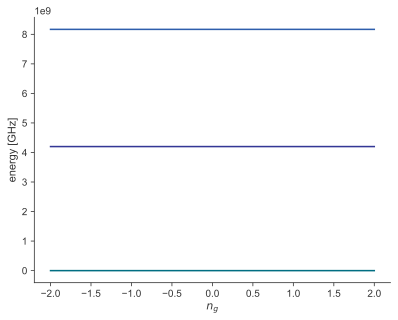

In [9]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej[0], EC=EC[0], ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [10]:
corrected_rr_freq = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cir = Network([
        C(0,1,c_sigma_unloaded), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r[i] - cqrs[i]), # resonator
        L(0,2,l_r[i]),
        C(1,2, cqrs[i]), # coupling capacitor
        R(0, 2, 1e6)
        ])
    # f,k,A,chi = 
    cir.f_k_A_chi(pretty_print=True, Lj = Ljs[i])
    ham = cir.hamiltonian(modes = [0, 1],
                        taylor = 6,
                        excitations = [10, 10],
                        Lj = Ljs[i])
    ee = ham.eigenenergies()
    ee -= ee[0]
    corrected_rr_freq[i] = ee[2]


         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.42 GHz |       168 Hz |      205 MHz |
            1 |        7 GHz |      550 kHz |       305 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      205 MHz |              |
            1 |      500 kHz |       305 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.42 GHz |       164 Hz |      205 MHz |
            1 |      7.1 GHz |      558 kHz |       305 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      205 MHz |              |
            1 |      500 kHz |       305 Hz |



 C:\Users\labranca\AppData\Local\Temp\ipykernel_12516\633708405.py: 19

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.42 GHz |       159 Hz |      204 MHz |
            1 |      7.2 GHz |      566 kHz |       306 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      204 MHz |              |
            1 |      500 kHz |       306 Hz |

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.41 GHz |       155 Hz |      204 MHz |
            1 |      7.3 GHz |      574 kHz |       306 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      204 MHz |              |
            1 |      500 kHz |       306 Hz |



In [11]:
g = 2*np.pi*EC_unloaded/ (e_charge) * (Ej/EC_unloaded/2)**(1/4) * cqrs / (c_r) * np.sqrt(2*planck_h * rr_freq_target * (c_r))
delta = (rr_freq_target - qubit_01) * 2*np.pi

lamb_shift = 2*g**2 / delta / 2 / np.pi
lamb_shift

array([4158429.36002315, 4294688.20457037, 4428992.31764634,
       4561417.1822915 ])

In [12]:
def minimize_for_ck(x, resonator_frequency):
    k = resonator_kappa(resonator_frequency, x[0]*1e-15, Z0)/ 2/ pi / np.sqrt(2)
    return abs(k - kappa_target)

In [13]:
cks = np.zeros((nb_qubits))
for i in range(nb_qubits):
    cks[i] = fsolve(minimize_for_ck, 5, args = (rr_freq_target[i]))[0]*1e-15
    

In [28]:
# Investigate more
resonator_waveguide_capacitance = c_r - cqr_to_ground(cqrs) - ck_to_ground(cks)

digit_cap_inductance = 1e-10 # Simulate this
tee_cap_inductance = 1e-10 # Simulate this
resonator_waveguide_inductance = l_r - digit_cap_inductance - tee_cap_inductance
rr_cap_ratio = resonator_waveguide_capacitance / c_r
resonator_waveguide_capacitance = resonator_waveguide_capacitance - np.array(cqrs) - np.array(cks)
c_l, l_l = cpw_cl_ll(a, b, ep_r)
resonator_waveguide_lengths = np.pi * np.sqrt((resonator_waveguide_capacitance * resonator_waveguide_inductance) / (c_l*l_l))
resonator_waveguide_lengths

array([0.00745494, 0.00733638, 0.00722118, 0.00710914])

In [33]:
coupler_width_given_c_qr, c_sigma_given_coupler_width = clockmon_coupling_libraries()
ck_given_finger_control = get_ck()
for i in range(nb_qubits):
    coupler_width = coupler_width_given_c_qr(cqrs[i])
    finger_control = ck_given_finger_control(cks[i])
    print(f"Coupler width for qubit {i}: {coupler_width:.5} um")
    print(f"Finger control for qubit {i}: {finger_control:.5}")
    print(f"Resonator length for qubit {i}: {resonator_waveguide_lengths[i]*1e6:.5} um")

Coupler width for qubit 0: 127.85 um
Finger control for qubit 0: 2.0865
Resonator length for qubit 0: 7454.9 um
Coupler width for qubit 1: 131.27 um
Finger control for qubit 1: 2.0687
Resonator length for qubit 1: 7336.4 um
Coupler width for qubit 2: 134.56 um
Finger control for qubit 2: 2.0513
Resonator length for qubit 2: 7221.2 um
Coupler width for qubit 3: 137.72 um
Finger control for qubit 3: 2.0344
Resonator length for qubit 3: 7109.1 um


In [34]:
fl_traits = pd.read_csv("single_clockmons_readout_structure00.csv").values[0][1:]
tee_size = pd.read_csv("single_clockmons_readout_structure00.csv").values[1][1:]
res_length = pd.read_csv("single_clockmons_readout_structure00.csv").values[2][1:]

tee_size = tee_size[pd.isna(tee_size) == 0]
res_length =res_length[pd.isna(res_length) == 0]

transmission_line_tee_points = []
transmission_line_tee_points += [float(fl_traits[0]) + (a+2*b)/2*1e6]
transmission_line_tee_points += [fl_traits[1] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[2] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[3] + (a+2*b)*1e6]
transmission_line_tee_points += [fl_traits[4] + (a+2*b)/2*1e6]

In [ ]:
resonator_capacitance = c_r -cks -  cqrs

options = {
    "qubit_c": np.array([c_sigma_unloaded]*4),
    "qubit_l": Ljs,
    "readout_resonator_c": resonator_capacitance,
    "readout_resonator_l": l_r,
    "ck": cks,
    "cqr": cqrs,
    "feedline_traits": transmission_line_tee_points,
    "frequency": [7.29, 7.31],
    "n_points": 1001,
    "type": "simple"
}

2-Port Network: '',  7.29-7.31 GHz, 1001 pts, z0=[50.+0.j 50.+0.j]


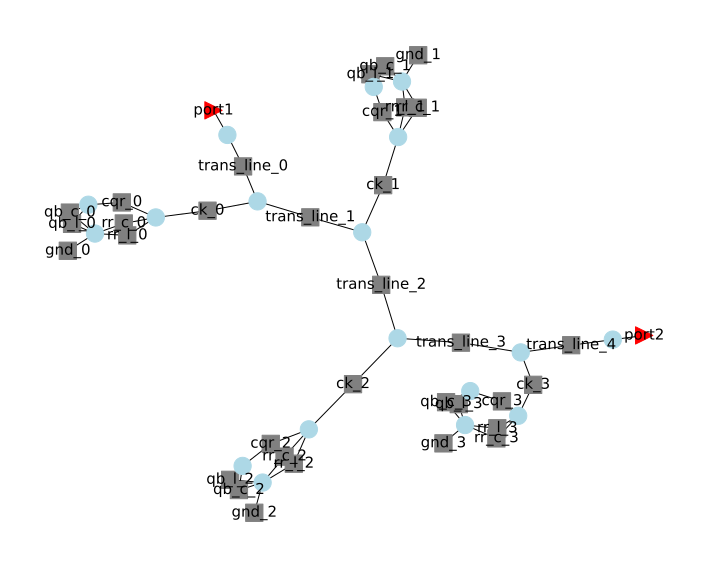

In [ ]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

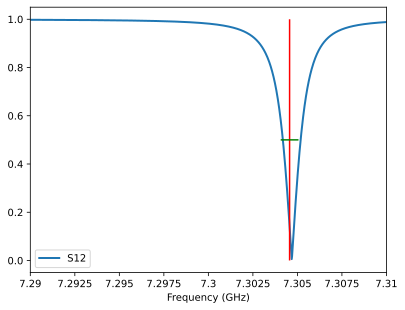

In [ ]:
ntw.plot_s_mag(m=0, n=1, lw=2)
import matplotlib.pyplot as plt
# plt.vlines(x = 1/np.sqrt(c_r*l_r) / 2 / np.pi, ymin = 0, ymax = 1, colors="red")

# plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi +lamb_shift[-1], ymin = 0, ymax = 1, colors="red")
# plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
#            xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

plt.vlines(x = 1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi +lamb_shift[-1], ymin = 0, ymax = 1, colors="red")
plt.hlines(y = 0.5, xmin =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi - kappa_target/2 +lamb_shift[-1],
           xmax =  1/np.sqrt(c_r[-1]*l_r[-1]) / 2 / np.pi  + kappa_target/2 +lamb_shift[-1], colors="green")

In [ ]:
lamb_shift

array([4158429.36002315, 4294688.20457037, 4428992.31764634,
       4561417.1822915 ])